In [1]:
! git clone https://github.com/Duckkyy/3rd_year_experiment.git

Cloning into '3rd_year_experiment'...
remote: Enumerating objects: 37108, done.
remote: Counting objects: 100% (2212/2212), done.
remote: Compressing objects: 100% (2089/2089), done.
remote: Total 37108 (delta 112), reused 2212 (delta 112), pack-reused 34896
Receiving objects: 100% (37108/37108), 913.42 MiB | 33.65 MiB/s, done.
Resolving deltas: 100% (14156/14156), done.
Checking out files: 100% (38757/38757), done.


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

import pandas as pd
from __future__ import division
torch.manual_seed(0)
from torch.autograd import Variable
from PIL import Image, ImageOps, ImageEnhance
plt.ion()


# New Section

In [6]:
transforming_hymen_data = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

data_dir = '3rd_year_experiment/emotions/data'
datasets_images = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          transforming_hymen_data[x])
                  for x in ['train', 'val']}
loaders_data = {x: torch.utils.data.DataLoader(datasets_images[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
sizes_datasets = {x: len(datasets_images[x]) for x in ['train', 'val']}
class_names = datasets_images['train'].classes

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
class_names = datasets_images['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
print(class_names)
print(device)

['1', '2', '3', '4', '5', '6', '7']
cuda:0


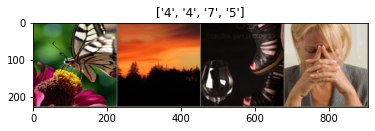

In [9]:
def visualize_data(input, title=None):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    if title is not None:
       plt.title(title)
    plt.pause(0.001)  ## Here we are pausing a bit so that plots are updated


inputs_data, classes = next(iter(loaders_data['train']))
## This is the code for getting a batch of training data

out = torchvision.utils.make_grid(inputs_data)
## Here we are making a grid from batch

visualize_data(out, title=[class_names[x] for x in classes])

In [10]:
def train(res_model, criterion, optimizer, scheduler, number_epochs=25):

    since = time.time()

    best_resmodel_wts = copy.deepcopy(res_model.state_dict())
    best_accuracy = 0.0

    for epochs in range(number_epochs):
        print('Epoch {}/{}'.format(epochs, number_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']: ## Here each epoch is having a training and validation phase
            res_model.train()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loaders_data[phase]: ## Iterating over data.
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() ## here we are making the gradients to zero

                with torch.set_grad_enabled(phase == 'train'): ## forwarding and then tracking the history if only in train
                     outputs = res_model(inputs)
                     _, preds = torch.max(outputs, 1)
                     loss = criterion(outputs, labels)

                     if phase == 'train': # backward and then optimizing only if it is in training phase
                         loss.backward()
                         optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / sizes_datasets[phase]
            epoch_acc = running_corrects.double() / sizes_datasets[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_accuracy))

    # load best model weights
    res_model.load_state_dict(best_resmodel_wts)

    # save model
    torch.save(res_model.state_dict(), f'{epochs:03}ep_acc{best_accuracy:.2f}.pth')

    return res_model



In [11]:
def model_visualization(res_model, num_images=6):

    was_training = res_model.training
    res_model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loaders_data['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = res_model(inputs)
            _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            visualize_data(inputs.cpu().data[j])

            if images_so_far == num_images:
               res_model.train(mode=was_training)
               return
        res_model.train(mode=was_training)

In [12]:
finetune_model = models.resnet50(pretrained=True)
num_ftrs = finetune_model.fc.in_features

finetune_model.fc = nn.Linear(num_ftrs, 7)
finetune_model = finetune_model.to(device)

criterion = nn.CrossEntropyLoss()
finetune_optim = optim.SGD(finetune_model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(finetune_optim, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [13]:
finetune_model = train(finetune_model, criterion, finetune_optim, exp_lr_scheduler, number_epochs=25)

Epoch 0/24
----------
train Loss: 1.8647 Acc: 0.3251
val Loss: 1.7429 Acc: 0.3614
Epoch 1/24
----------
train Loss: 1.6794 Acc: 0.3816
val Loss: 1.9082 Acc: 0.3614
Epoch 2/24
----------
train Loss: 1.5445 Acc: 0.4109
val Loss: 1.6664 Acc: 0.3976
Epoch 3/24
----------
train Loss: 1.5015 Acc: 0.4495
val Loss: 1.6256 Acc: 0.3735
Epoch 4/24
----------
train Loss: 1.4321 Acc: 0.4614
val Loss: 1.6372 Acc: 0.4819
Epoch 5/24
----------
train Loss: 1.4335 Acc: 0.4535
val Loss: 1.6134 Acc: 0.4096
Epoch 6/24
----------
train Loss: 1.3680 Acc: 0.4980
val Loss: 1.6403 Acc: 0.3614
Epoch 7/24
----------
train Loss: 1.2150 Acc: 0.5605
val Loss: 1.6053 Acc: 0.4819
Epoch 8/24
----------
train Loss: 1.1446 Acc: 0.5838
val Loss: 1.4183 Acc: 0.5301
Epoch 9/24
----------
train Loss: 1.1325 Acc: 0.5851
val Loss: 1.5343 Acc: 0.4096
Epoch 10/24
----------
train Loss: 1.0956 Acc: 0.5884
val Loss: 1.5154 Acc: 0.4699
Epoch 11/24
----------
train Loss: 1.0878 Acc: 0.6017
val Loss: 1.6035 Acc: 0.5181
Epoch 12/24
--

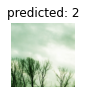

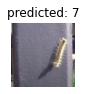

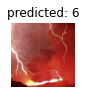

In [14]:
model_visualization(finetune_model)

In [15]:
def prediction(res_model, image_path):

    im = Image.open(image_path)
    im_tensor = transforming_hymen_data['test'](im).unsqueeze(0)

    image = Image.open(image_path).convert('RGB')
    image_tensor = transforming_hymen_data['test'](image)
    image_tensor = image_tensor.unsqueeze_(0).to(device) 
    input_img = Variable(image_tensor)
    output = res_model(input_img)
    #print(output)
    index = output.cpu().data.numpy().argmax()
    pred = class_names[index]
    return pred 


In [16]:
from tqdm.auto import tqdm

test_path = "3rd_year_experiment/emotions/data/test"
label_path = "3rd_year_experiment/emotions/Labels"
image_path = '3rd_year_experiment/emotions/datasets'

test_label_path = os.path.join(label_path, "ground_truth_test.csv")

test_df = pd.read_csv(test_label_path)
iterow = list(test_df.iterrows())

for idx, row in tqdm(iterow):
        test_image_path = os.path.join(image_path, row["image"])

        pred = prediction(finetune_model, test_image_path)

        test_df.loc[test_df["image"]==row["image"], "label"] = pred

test_df = test_df.astype({'label': 'int32'})

test_df.to_csv("sample_submission.csv", index=False)

  0%|          | 0/393 [00:00<?, ?it/s]